In [1]:
from pyrsgis import raster
from pyrsgis.convert import changeDimension
from sklearn.model_selection import train_test_split
from tensorflow import keras

from sklearn.metrics import confusion_matrix, precision_score, recall_score

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import rasterio as rio
from rasterio.merge import merge
from rasterio.plot import show
from rasterio import plot
import matplotlib.pyplot as plt
import numpy as np
from  glob import glob


%matplotlib inline

In [2]:
images = glob("*.tif")

images

['L8_2021_Dec.tif',
 'L8_2021_Jan.tif',
 'NDBI.tif',
 'NDVI.tif',
 'Predicted_2021_BuiltupNN2.tif',
 'S_2021_12.tif',
 'Thimphu_Builtup_mask.tif',
 'Thimphu_Builtup_mask_clean.tif']

In [3]:
train_mx = "L8_2021_Jan.tif"
predict_mx = "L8_2021_Dec.tif"
train_builtup ="Thimphu_Builtup_mask_clean.tif"

In [4]:
ds1, train_mx_array  = raster.read(train_mx,bands="all")
train_mx_array

array([[[ 7331,  7224,  7134, ...,  7187,  7233,  7391],
        [ 7234,  7185,  7091, ...,  7215,  7257,  7310],
        [ 7188,  7102,  6984, ...,  7284,  7335,  7320],
        ...,
        [ 7418,  7419,  7407, ...,  6884,  6857,  6847],
        [ 7446,  7397,  7406, ...,  6898,  6920,  6947],
        [ 7423,  7406,  7412, ...,  6914,  7005,  7005]],

       [[ 7779,  7475,  7495, ...,  7286,  7358,  7504],
        [ 7553,  7555,  7441, ...,  7321,  7393,  7437],
        [ 7567,  7444,  7349, ...,  7395,  7454,  7436],
        ...,
        [ 7649,  7626,  7616, ...,  7081,  7083,  7138],
        [ 7583,  7531,  7582, ...,  7132,  7151,  7223],
        [ 7593,  7574,  7601, ...,  7196,  7333,  7325]],

       [[ 8717,  8536,  8553, ...,  7479,  7599,  7856],
        [ 8556,  8464,  8338, ...,  7527,  7658,  7725],
        [ 8576,  8309,  8224, ...,  7716,  7841,  7798],
        ...,
        [ 8123,  8097,  7976, ...,  7503,  7478,  7573],
        [ 8079,  8094,  8097, ...,  7557,  76

In [5]:
ds1, predict_mx_array  = raster.read(predict_mx,bands="all")
predict_mx_array

array([[[ 7649,  7629,  7621, ...,  7233,  7298,  7406],
        [ 7631,  7555,  7474, ...,  7343,  7336,  7406],
        [ 7524,  7499,  7456, ...,  7364,  7461,  7414],
        ...,
        [ 7222,  7217,  7124, ...,  6893,  6838,  6918],
        [ 7222,  7154,  7133, ...,  6894,  6926,  7011],
        [ 7190,  7176,  7139, ...,  6916,  7043,  7045]],

       [[ 8114,  7967,  7913, ...,  7353,  7439,  7553],
        [ 7945,  7922,  7844, ...,  7388,  7440,  7488],
        [ 7864,  7870,  7747, ...,  7483,  7563,  7525],
        ...,
        [ 7673,  7674,  7611, ...,  7122,  7102,  7134],
        [ 7652,  7600,  7582, ...,  7144,  7210,  7256],
        [ 7617,  7621,  7622, ...,  7200,  7337,  7329]],

       [[ 9020,  8807,  8874, ...,  7551,  7669,  7886],
        [ 8878,  8824,  8791, ...,  7599,  7753,  7772],
        [ 8835,  8744,  8682, ...,  7774,  7966,  7883],
        ...,
        [ 8536,  8588,  8469, ...,  7487,  7485,  7543],
        [ 8462,  8454,  8446, ...,  7566,  76

In [6]:
ds1, train_builtup_array  = raster.read(train_builtup,bands=1)
train_builtup_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

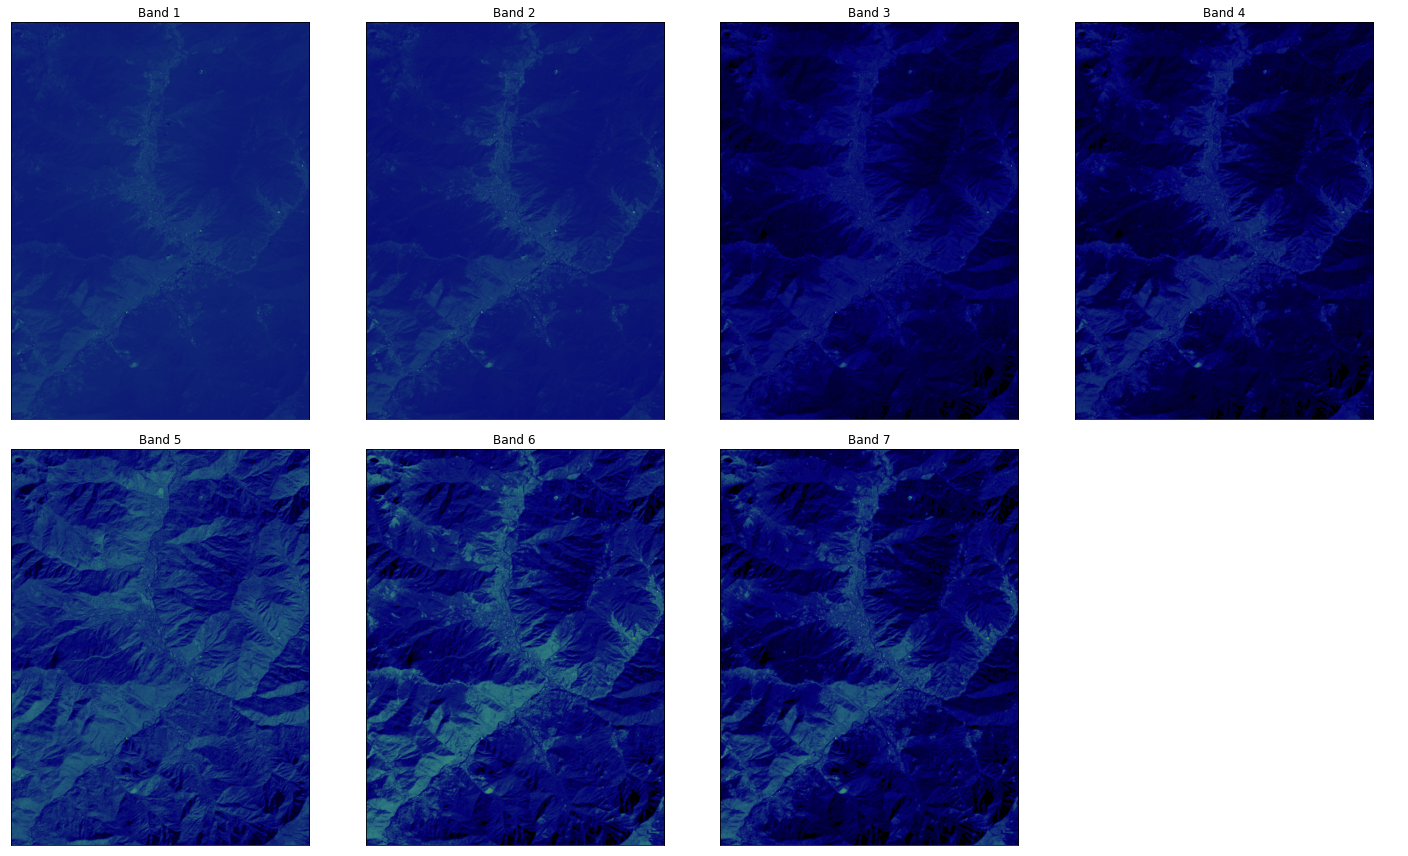

In [7]:
ep.plot_bands(train_mx_array, cmap = 'gist_earth', figsize = (20, 12), cols =4,cbar = False)
plt.show()

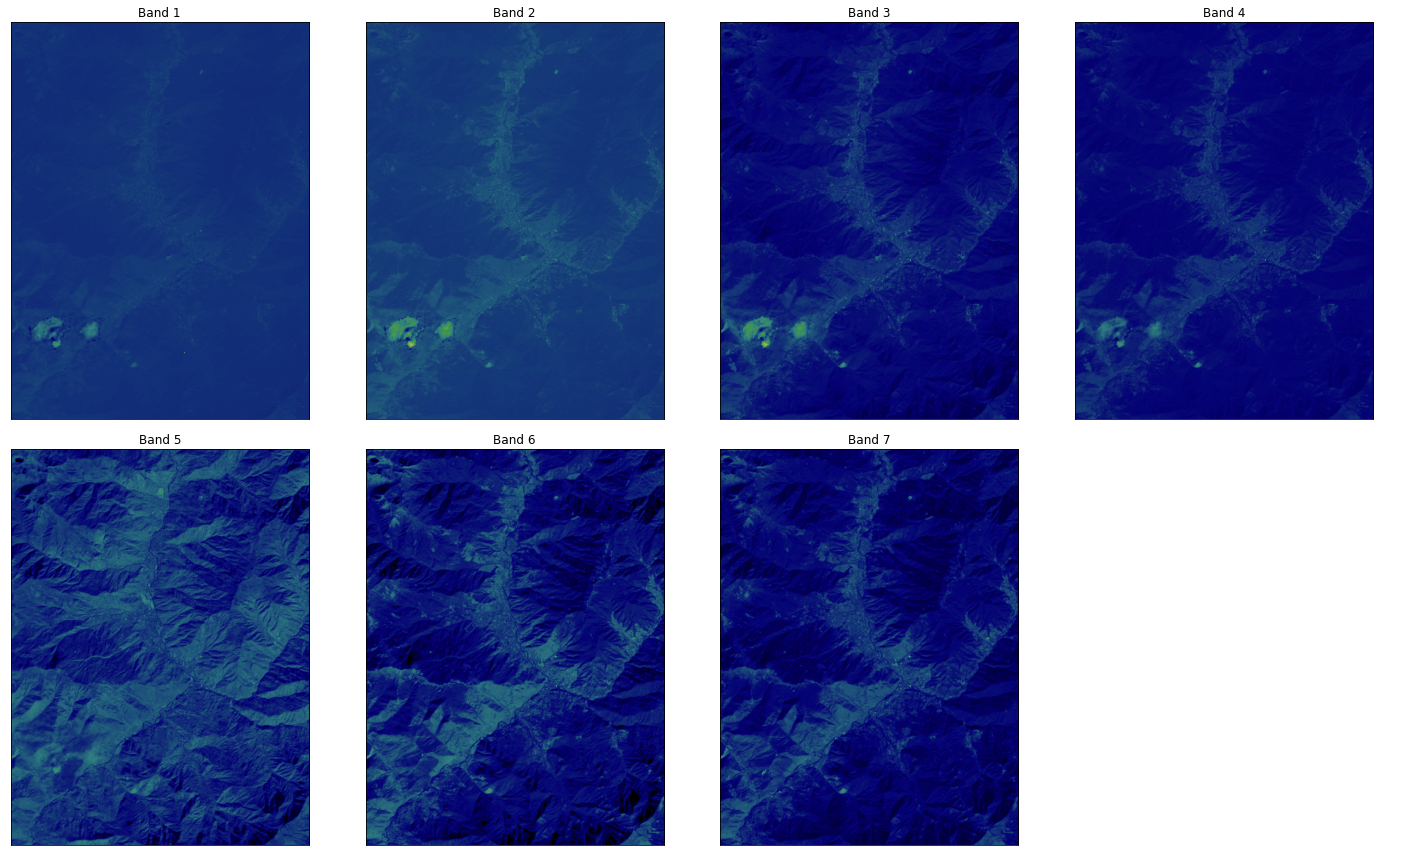

In [8]:
ep.plot_bands(predict_mx_array, cmap = 'gist_earth', figsize = (20, 12), cols =4,cbar = False)
plt.show()

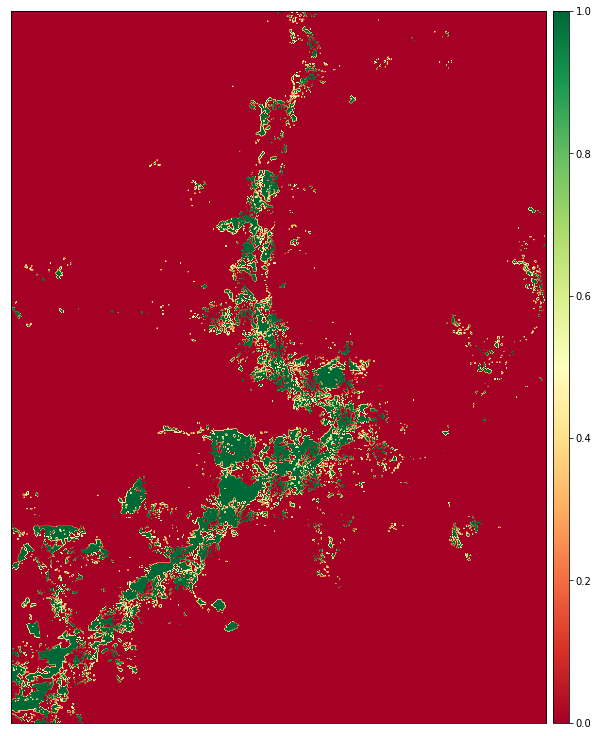

In [9]:
ep.plot_bands(train_builtup_array, cmap="RdYlGn",figsize=(10, 14))

plt.show()

## Neural Network

In [10]:
ds1, featuresTrain = raster.read(train_mx,bands='all')
ds2, labelTrain = raster.read(train_builtup, bands=1)
ds3, featuresPredict = raster.read(predict_mx, bands='all')

## printing data size

In [11]:
print("train_mx shape: ", featuresTrain.shape)
print("train_builtup shape: ", labelTrain.shape)
print("predict_mx shape: ", featuresPredict.shape)

train_mx shape:  (7, 734, 552)
train_builtup shape:  (734, 552)
predict_mx shape:  (7, 734, 552)


## Changing Dimension of data

In [12]:
featuresTrain = changeDimension(featuresTrain)
labelTrain = changeDimension (labelTrain)
featuresPredict = changeDimension(featuresPredict)
nBands = featuresTrain.shape[1]
labelTrain = (labelTrain == 1).astype(int)


The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.


## Verifying dimension change

In [13]:
print("train_mx shape: ", featuresPredict.shape)
print("train_builtup shape: ", labelTrain.shape)
print("predict_mx shape: ", featuresPredict.shape)

train_mx shape:  (405168, 7)
train_builtup shape:  (405168,)
predict_mx shape:  (405168, 7)


## Training dataset

In [14]:
xTrain, xTest, yTrain, yTest = train_test_split(featuresTrain, labelTrain, test_size=0.4, random_state=42)

print(xTrain.shape)
print(yTrain.shape)

(243100, 7)
(243100,)


# Normalise the data

In [15]:
xTrain = xTrain / 255.0
xTest = xTest / 255.0
featuresPredict = featuresPredict / 255.0

In [16]:
print(xTrain.shape)
print(xTest.shape)
print(featuresPredict.shape)

(243100, 7)
(162068, 7)
(405168, 7)


## Reshape the data

In [17]:
xTrain = xTrain.reshape((xTrain.shape[0], 1, xTrain.shape[1]))
xTest = xTest.reshape((xTest.shape[0], 1, xTest.shape[1]))
featuresPredict = featuresPredict.reshape((featuresPredict.shape[0], 1, featuresPredict.shape[1]))


## Verifying reshaped 

In [18]:
print(xTrain.shape, xTest.shape, featuresPredict.shape)

(243100, 1, 7) (162068, 1, 7) (405168, 1, 7)


## Define model parameters

In [19]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, nBands)),
    keras.layers.Dense(14, activation='relu'),
    keras.layers.Dense(2, activation='softmax')])

## Define the accuracy metrics and parameters

In [20]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [21]:
## Run the model

In [23]:
model.fit(xTrain, yTrain, epochs=5)

Epoch 1/5
243100/243100 [==============================] - 9s 38us/step - loss: 0.0525 - acc: 0.9786
Epoch 2/5
243100/243100 [==============================] - 9s 38us/step - loss: 0.0499 - acc: 0.9795
Epoch 3/5
243100/243100 [==============================] - 9s 38us/step - loss: 0.0470 - acc: 0.9811
Epoch 4/5
243100/243100 [==============================] - 10s 39us/step - loss: 0.0458 - acc: 0.9817
Epoch 5/5
243100/243100 [==============================] - 9s 38us/step - loss: 0.0447 - acc: 0.9819


## Predict for test data 

In [24]:
yTestPredicted = model.predict(xTest)
yTestPredicted = yTestPredicted[:,1]

## Calculate and display the error metrics

In [25]:
yTestPredicted = (yTestPredicted>0.5).astype(int)
cMatrix = confusion_matrix(yTest, yTestPredicted)
pScore = precision_score(yTest, yTestPredicted)
rScore = recall_score(yTest, yTestPredicted)

## Printing the score

In [26]:
print("Confusion matrix: for 14 nodes\n", cMatrix)
print("\nP-Score: %.3f, R-Score: %.3f" % (pScore, rScore))

Confusion matrix: for 14 nodes
 [[150943    774]
 [  1998   8353]]

P-Score: 0.915, R-Score: 0.807


## Export the predicted area

In [27]:
predicted = model.predict(featuresPredict)
predicted = predicted[:,1]


prediction = np.reshape(predicted, (ds3.RasterYSize, ds3.RasterXSize))
outFile = 'Predicted_2021_BuiltupNN2.tif'
raster.export(prediction, ds3, filename=outFile, dtype='float')

## Display predicted Image

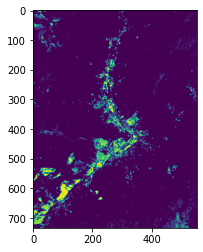

<AxesSubplot:>

In [28]:
show(prediction)